# Modelos de Regressão: y = quality

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from math import sqrt

In [217]:
def trata_dataframe(df):
    # Para eliminar o 3º tipo, contamos os pontos do valor em 'alcohol' e salvamos numa coluna 'count_dots'
    df['count_dots'] = df['alcohol'].str.count('\.')
    df.loc[df['count_dots'] == 4, 'alcohol'] = np.nan # Convertemos strings sem sentido em NaNs
    df.dropna(inplace=True) # Dropamos as linhas com NaN
    df = df.drop(['count_dots'], axis=1) # Não é mais necessária

    # Convertemos o que sobrar para float
    df['alcohol'] = pd.to_numeric(df['alcohol'])

    # Dropamos todos os casos em que densidade > 1.5 (136 apenas e o mesmo que a qtd de casos > 10 inclusive); então:
    df.drop(df[df['density'] > 1.5].index, inplace=True)
    
    return df

def resultados(y_test, y_prediction):
    RMSE = sqrt(mean_squared_error(y_true=y_test, y_pred=y_prediction))
    print('\nRMSE: {}'.format(RMSE))
    
    df_result = pd.DataFrame({'n': range(0, len(y_test)), 'y_test': y_test, 'y_prediction': y_prediction, 'error': y_test-y_prediction})
    y_max = df_result['y_test'].describe()['max']
    y_min = df_result['y_test'].describe()['min']
    NRMSE = RMSE / (y_max - y_min)
    print('\nRMSE normalizado: {}'.format(NRMSE))
    df_result.head(10)

    # Histograma do erro
    plt.figure(figsize=(10, 10))
    sns.distplot(df_result['error'], bins=10, norm_hist=True, kde=False)
    plt.show()
    
    # Gráfico do erro
    plt.figure(figsize=(20, 5))
    plt.hlines(y=0, xmin=4, xmax=len(df_result['n']), linewidth=5, color='black')
    sns.lineplot(x='n', y='error', data=df_result)
    plt.show()
    
    return df_result.head(10)

In [201]:
# Carregamos o dataset
df = pd.read_csv('/home/watson/proj-cognitivo/wine_modelling/winequality.csv', delimiter=';')
df = trata_dataframe(df)
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# 1. Auto-sklearn
Busca do melhor modelo: algoritmo + tuning de hiperparâmetros

## 1.1. Modelo

In [ ]:
import sklearn.model_selection
import sklearn.metrics
import autosklearn.regression

In [62]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [63]:
#Encoding dados categóricos
from sklearn.preprocessing import LabelEncoder
labelencoder_X = LabelEncoder()
X[:, 0] = labelencoder_X.fit_transform(X[:, 0])
X

array([[1, 7.0, 0.27, ..., 3.0, 0.45, 8.8],
       [1, 6.3, 0.3, ..., 3.3, 0.49, 9.5],
       [1, 8.1, 0.28, ..., 3.26, 0.44, 10.1],
       ...,
       [0, 6.3, 0.51, ..., 3.42, 0.75, 11.0],
       [0, 5.9, 0.645, ..., 3.57, 0.71, 10.2],
       [0, 6.0, 0.31, ..., 3.39, 0.66, 11.0]], dtype=object)

In [67]:
feature_types = (['categorical'] + ['numerical'] * 11)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=1)

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=3600,
    per_run_time_limit=360,
    tmp_folder='/home/watson/proj-cognitivo/automl_tmp',
    output_folder='/home/watson/proj-cognitivo/automl_output',
)
automl.fit(X_train, y_train, dataset_name='wine', feat_type=feature_types)

print(automl.show_models())
predictions = automl.predict(X_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

[WARNING] [2018-10-22 03:31:59,022:AutoMLSMBO(1)::wine] Could not find meta-data directory /home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/metalearning/files/r2_regression_dense
[WARNING] [2018-10-22 03:31:59,036:EnsembleBuilder(1):wine] No models better than random - using Dummy Classifier!
[WARNING] [2018-10-22 03:31:59,078:EnsembleBuilder(1):wine] No models better than random - using Dummy Classifier!


/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is

[WARNING] [2018-10-22 03:32:01,088:EnsembleBuilder(1):wine] No models better than random - using Dummy Classifier!


/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
Exception ignored in: <bound method BackendContext.__del__ of <autosklearn.util.backend.BackendContext object at 0x7fdc0cedbb70>>
Traceback (most recent call last):
  File "/hom

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:


[(0.720000, SimpleRegressionPipeline({'categorical_encoding:__choice__': 'one_hot_encoding', 'imputation:strategy': 'mean', 'preprocessor:__choice__': 'no_preprocessing', 'regressor:__choice__': 'random_forest', 'rescaling:__choice__': 'standardize', 'categorical_encoding:one_hot_encoding:use_minimum_fraction': 'True', 'regressor:random_forest:bootstrap': 'True', 'regressor:random_forest:criterion': 'mse', 'regressor:random_forest:max_depth': 'None', 'regressor:random_forest:max_features': 1.0, 'regressor:random_forest:max_leaf_nodes': 'None', 'regressor:random_forest:min_impurity_decrease': 0.0, 'regressor:random_forest:min_samples_leaf': 1, 'regressor:random_forest:min_samples_split': 2, 'regressor:random_forest:min_weight_fraction_leaf': 0.0, 'regressor:random_forest:n_estimators': 100, 'categorical_encoding:one_hot_encoding:minimum_fraction': 0.01},
dataset_properties={
  'task': 4,
  'sparse': False,
  'multilabel': False,
  'multiclass': False,
  'target_type': 'regression',
  's

## 1.2. Resultados


RMSE: 0.6406464187857602


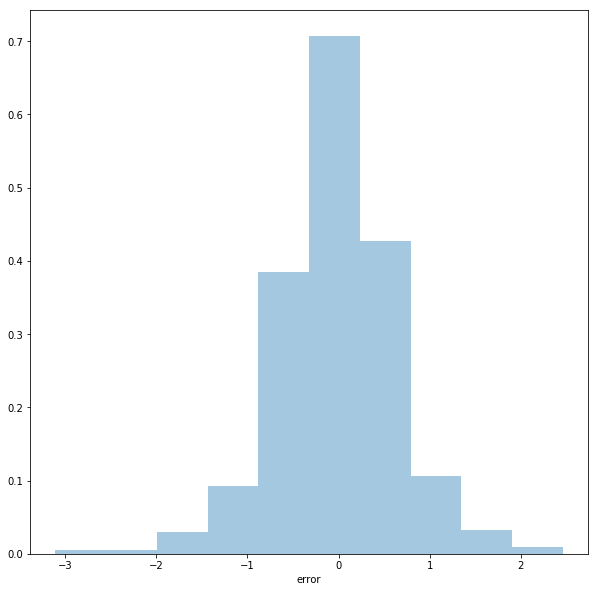

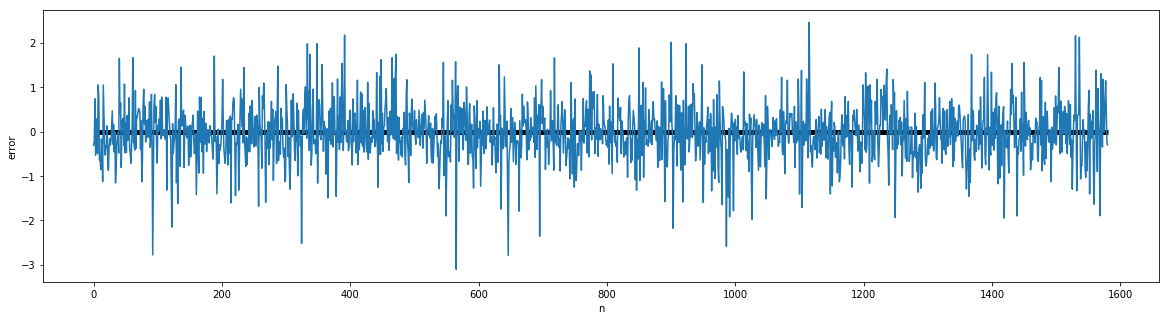

,error,n,y_prediction,y_test
0,-0.309046,0,6.309046,6
1,-0.203880,1,5.203880,5
2,0.738556,2,6.261444,7
3,-0.535681,3,6.535681,6
4,-0.106869,4,5.106869,5
5,0.290620,5,5.709380,6
6,-0.499539,6,5.499539,5
7,1.049295,7,4.950705,6
8,0.724591,8,6.275409,7
9,-0.642009,9,6.642009,6


In [188]:
resultados(y_test, y_prediction)

# 2. Regressão linear de múltiplas variáveis

## 2.1. Modelo

In [203]:
X2 = df.iloc[:, :-1].values
y2 = df.iloc[:, -1].values

#Encoding dados categóricos
from sklearn.preprocessing import LabelEncoder
labelencoder_X = LabelEncoder()
X2[:, 0] = labelencoder_X.fit_transform(X2[:, 0])

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=7)

In [204]:
regressor2 = LinearRegression()
regressor2.fit(X_train2, y_train2)

y_prediction2 = regressor2.predict(X_test2)

## 2.2. Resultados


RMSE: 0.7549727251859886

RMSE normalizado: 0.1258287875309981


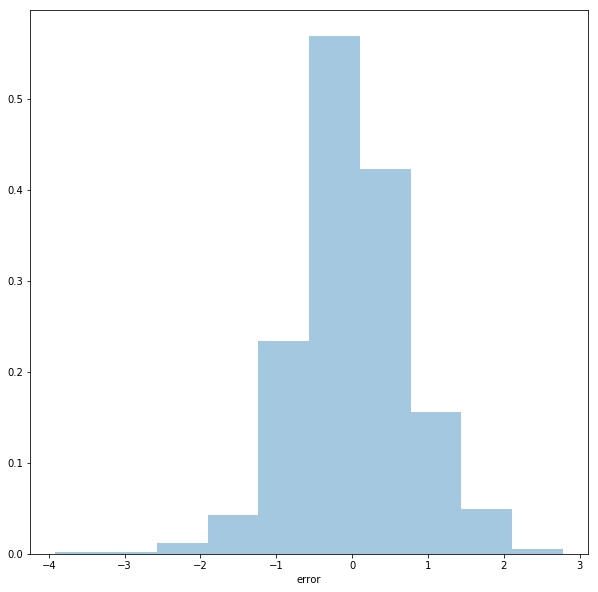

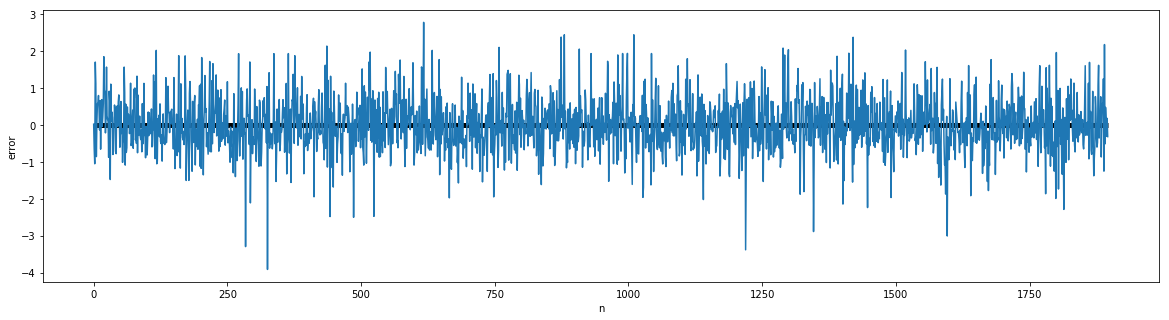

,error,n,y_prediction,y_test
0,0.020951,0,5.979049,6
1,-0.643470,1,5.643470,5
2,-1.051323,2,6.051323,5
3,1.701416,3,6.298584,8
4,1.122673,4,5.877327,7
5,-0.857423,5,5.857423,5
6,0.073760,6,5.926240,6
7,0.568998,7,5.431002,6
8,0.620979,8,5.379021,6
9,0.796549,9,5.203451,6


In [218]:
resultados(y_test2, y_prediction2)

# 3. Random Forest

## 3.1. Modelo

In [106]:
X3 = df.drop(['type'], axis=1).iloc[:, :-1].values
y3 = df.iloc[:, -1].values

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, random_state=7)

RMSE mínimo em max_depth=20.


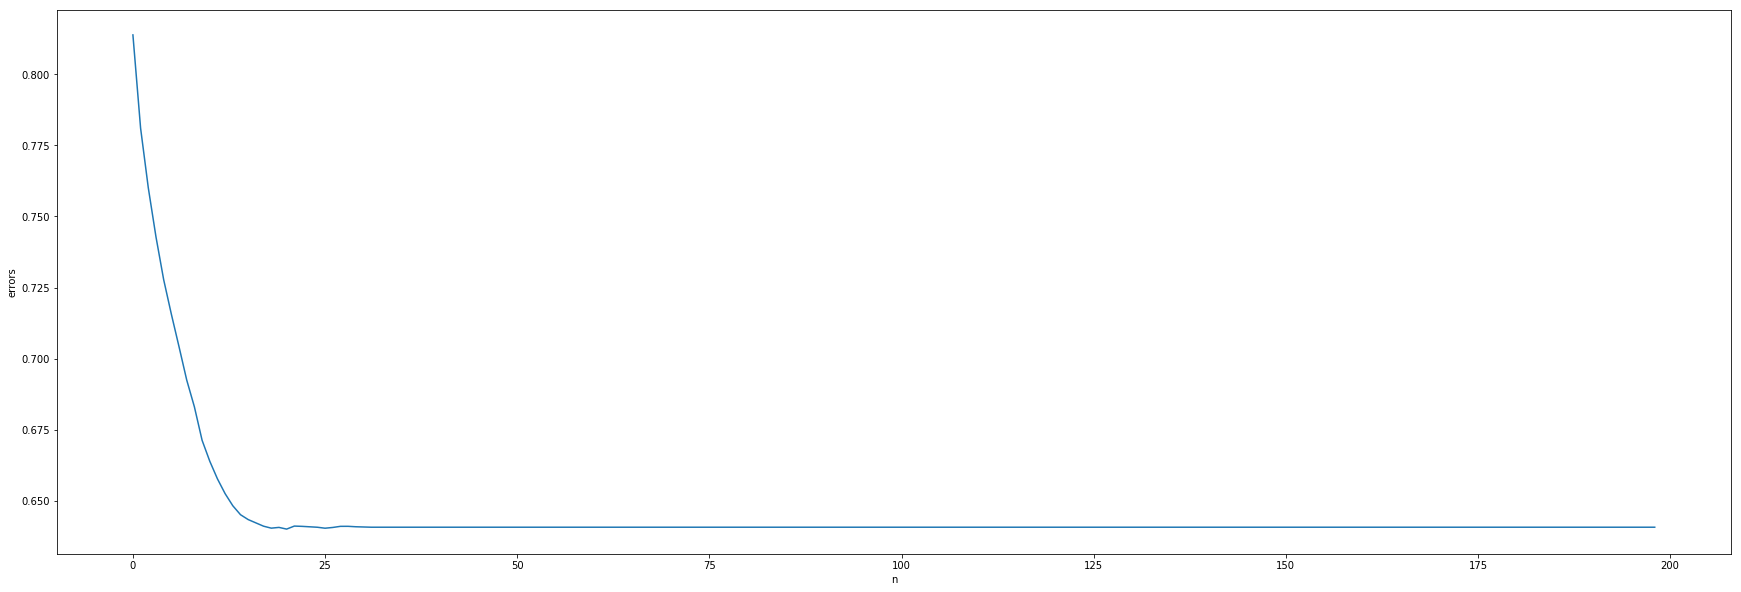

In [165]:
# Testando algumas possibilidades para max_depth
errors3 = []
for i in range(1, 200):
    regressor3 = RandomForestRegressor(max_depth=i, random_state=0, n_estimators=100)
    regressor3.fit(X_train3, y_train3)

    y_prediction3 = regressor3.predict(X_test3)
    
    RMSE = sqrt(mean_squared_error(y_true=y_test3, y_pred=y_prediction3))
    errors3.append(RMSE)
E3 = pd.DataFrame({'n': range(0, len(errors3)), 'errors': errors3})

n_min3 = E3[E3['errors'] == E3['errors'].min()]['n'].iloc[0]
print('RMSE mínimo em max_depth={}.'.format(n_min3))

# Gráfico do erro
plt.figure(figsize=(30, 10))
sns.lineplot(x='n', y='errors', data=E3)
plt.show()

In [166]:
regressor3 = RandomForestRegressor(max_depth=n_min3, random_state=0, n_estimators=100)
regressor3.fit(X_train3, y_train3)

y_prediction3 = regressor3.predict(X_test3)

## 3.2. Resultados


RMSE: 0.6406753773360365

RMSE normalizado: 0.10677922955600609


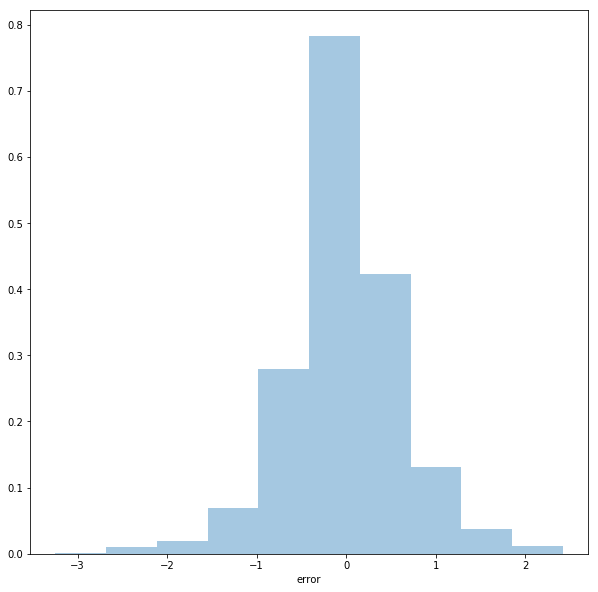

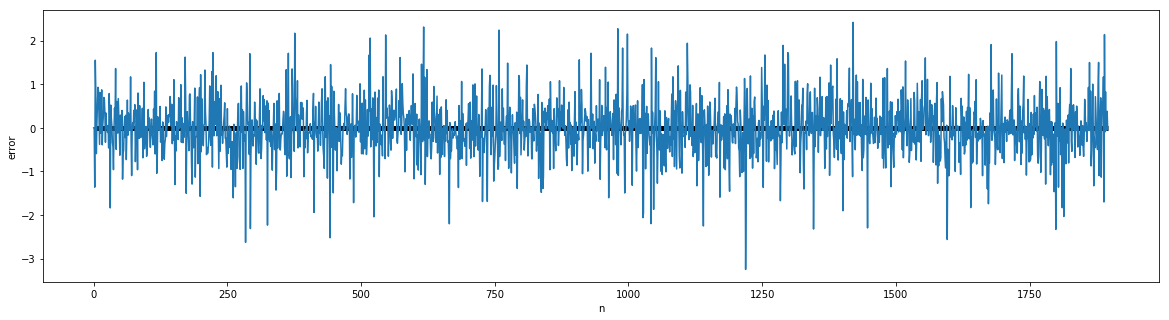

,error,n,y_prediction,y_test
0,-0.000162,0,6.000162,6
1,-0.011731,1,5.011731,5
2,-1.360537,2,6.360537,5
3,1.550529,3,6.449471,8
4,0.840080,4,6.159920,7
5,-0.591111,5,5.591111,5
6,0.073678,6,5.926322,6
7,0.486982,7,5.513018,6
8,0.930000,8,5.070000,6
9,0.846038,9,5.153962,6


In [219]:
resultados(y_test3, y_prediction3)

# 4. Decision Tree

## 4.1. Modelo

In [119]:
X4 = df.drop(['type'], axis=1).iloc[:, :-1].values
y4 = df.iloc[:, -1].values
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.3, random_state=7)

RMSE mínimo em max_depth=6.


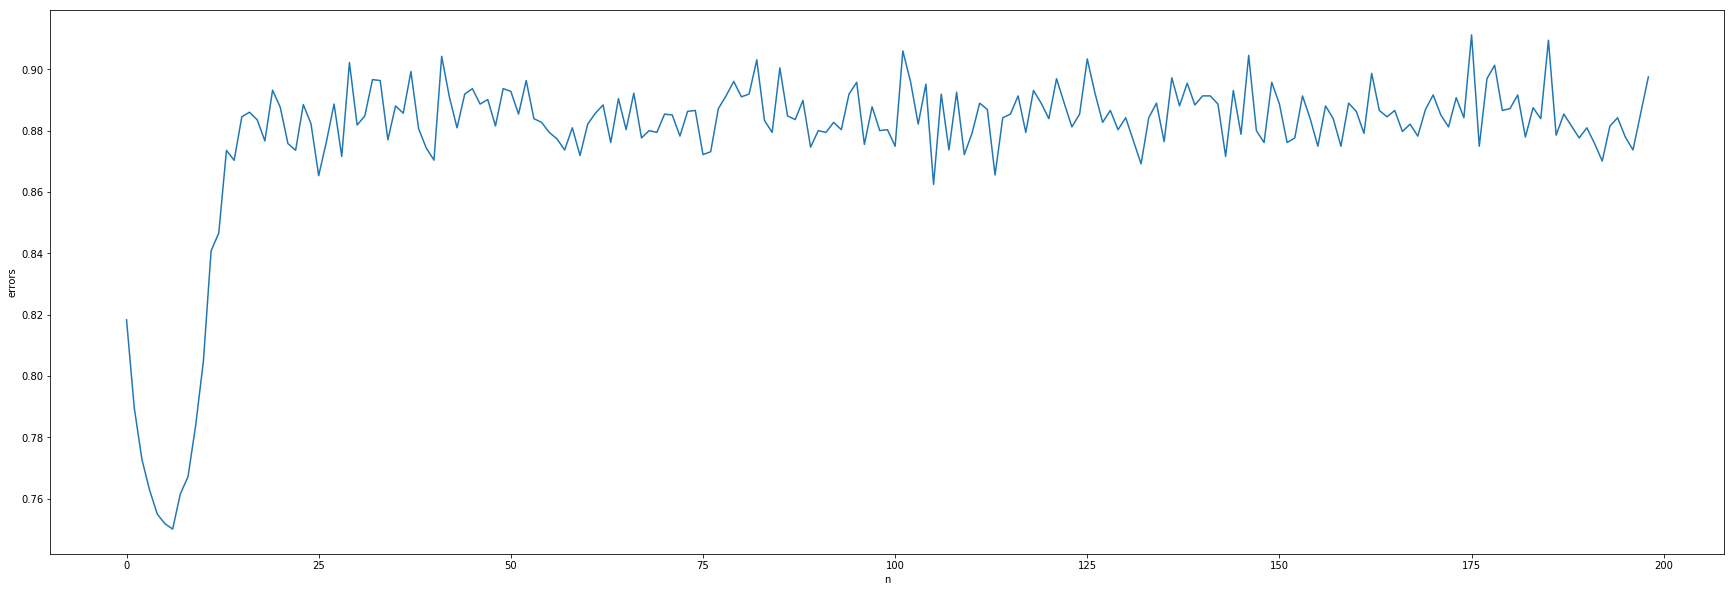

In [162]:
# Testando algumas possibilidades para max_depth
errors4 = []
for i in range(1, 200):
    regressor4 = DecisionTreeRegressor(max_depth=i)
    regressor4.fit(X_train4, y_train4)

    y_prediction4 = regressor4.predict(X_test4)
    
    RMSE = sqrt(mean_squared_error(y_true=y_test4, y_pred=y_prediction4))
    errors4.append(RMSE)
E4 = pd.DataFrame({'n': range(0, len(errors4)), 'errors': errors4})

n_min4 = E4[E4['errors'] == E4['errors'].min()]['n'].iloc[0]
print('RMSE mínimo em max_depth={}.'.format(n_min4))

# Gráfico do erro
plt.figure(figsize=(30, 10))
sns.lineplot(x='n', y='errors', data=E4)
plt.show()

In [163]:
regressor4 = DecisionTreeRegressor(max_depth=n_min4)
regressor4.fit(X_train4, y_train4)

y_prediction4 = regressor4.predict(X_test4)

## 4.2. Resultados


RMSE: 0.7517840300226785

RMSE normalizado: 0.12529733833711307


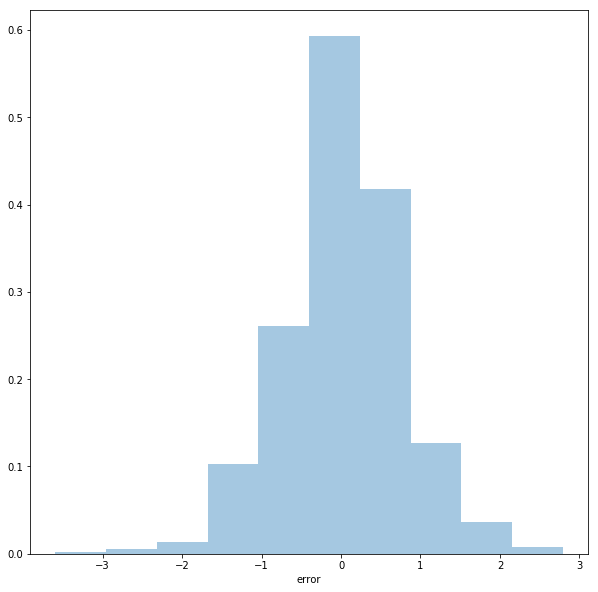

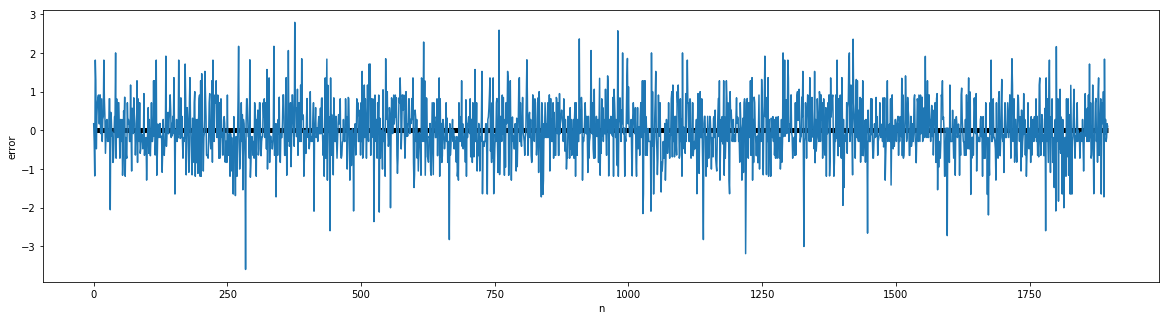

,error,n,y_prediction,y_test
0,0.171053,0,5.828947,6
1,-0.286957,1,5.286957,5
2,-1.177778,2,6.177778,5
3,1.814433,3,6.185567,8
4,1.280851,4,5.719149,7
5,-0.476821,5,5.476821,5
6,0.361702,6,5.638298,6
7,0.713043,7,5.286957,6
8,0.850000,8,5.150000,6
9,0.911894,9,5.088106,6


In [220]:
resultados(y_test4, y_prediction4)